In [1]:
import sys
sys.path.append('../')

import tensorflow as tf

from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import lib.utils as utils
import os
import cv2
import random

In [2]:
def convertImg(image, size=(32,32)):
    image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
    converted = np.zeros(shape=(size[0], size[1], 1))
    for y in range(0, len(image)):
        for x in range(0, len(image[y])):
            converted[y][x][0] = image[y][x]

    converted = converted/255
    return converted

In [3]:
# trainImages / Images
ratio = 0.7
train_data = []
test_data = []

class_names = os.listdir('./../resources/trainData')
print(class_names)

for class_name in class_names:
    data = os.listdir('./../resources/trainData/{class_name}'.format(class_name=class_name))
    for i in range(0, len(data)):
        image = convertImg(utils.loadImage(path='./../resources/trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))
        #image = convertImg(utils.loadImage(path='./trainData/{class_name}'.format(class_name=class_name), name=data[i], resize=(32,32)))

        label = [0 for i in range(0,len(class_names) + 4)]
        if 'u' in data[i]:
            label[len(label)-4] = 1
        if 'd' in data[i]:
            label[len(label)-3] = 1
        if 'l' in data[i]:
            label[len(label)-2] = 1
        if 'r' in data[i]:
            label[len(label)-1] = 1
        label[class_names.index(class_name)] = 1

        if(i/len(data) < ratio):
            train_data.append((image,label))
        else:
            test_data.append((image,label))

class_names += ['up', 'down', 'left', 'right']
print(class_names)

random.shuffle(train_data)
random.shuffle(test_data)

train_images = []
train_labels = []
test_images = []
test_labels = []

for data in train_data:
    train_images.append(data[0])
    train_labels.append(data[1])

for data in test_data:
    test_images.append(data[0])
    test_labels.append(data[1])


train_images = np.asarray(train_images)
train_labels = np.asarray(train_labels)
test_images = np.asarray(test_images)
test_labels = np.asarray(test_labels)

print(len(train_images))
print(len(test_images))

['capacitor', 'ground', 'resistor', 'up', 'down', 'left', 'right']
9
3


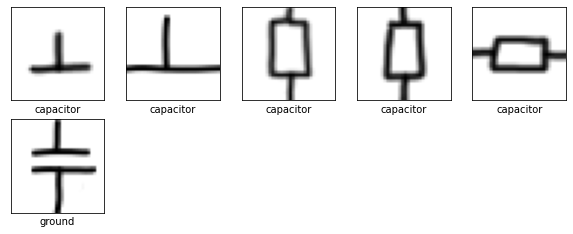

In [4]:
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(len(class_names)))
model.add(layers.Dense(len(class_names), activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [6]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
              

#history = model.fit(train_images, train_labels, epochs=10, 
#                    validation_data=(test_images, test_labels))

history = model.fit(train_images, train_labels, epochs=40, 
                    validation_data=(test_images, test_labels))


Epoch 1/40
1/1 [==============================] - 1s 548ms/step - loss: 0.6932 - binary_accuracy: 0.5556 - val_loss: 0.7049 - val_binary_accuracy: 0.4286
Epoch 2/40
1/1 [==============================] - 0s 34ms/step - loss: 0.6602 - binary_accuracy: 0.6349 - val_loss: 0.7232 - val_binary_accuracy: 0.3810
Epoch 3/40
1/1 [==============================] - 0s 22ms/step - loss: 0.6328 - binary_accuracy: 0.6349 - val_loss: 0.7639 - val_binary_accuracy: 0.4762
Epoch 4/40
1/1 [==============================] - 0s 16ms/step - loss: 0.6111 - binary_accuracy: 0.7143 - val_loss: 0.8295 - val_binary_accuracy: 0.4286
Epoch 5/40
1/1 [==============================] - 0s 32ms/step - loss: 0.5974 - binary_accuracy: 0.6825 - val_loss: 0.9015 - val_binary_accuracy: 0.4286
Epoch 6/40
1/1 [==============================] - 0s 22ms/step - loss: 0.5950 - binary_accuracy: 0.6825 - val_loss: 0.9280 - val_binary_accuracy: 0.4286
Epoch 7/40
1/1 [==============================] - 0s 13ms/step - loss: 0.5938 - b

In [7]:
model.save('./../resources/saved_model/my_model')

INFO:tensorflow:Assets written to: ./../resources/saved_model/my_model\assets


In [8]:
#boxes = [[[45,118],[80,184]],[[250,115],[300,141]]]
#image = utils.loadImage("../src/testImages", "1.png")

def classify(boxes, image):
    
    model = tf.keras.models.load_model('./../resources/saved_model/my_model')

    components = []
    for box in boxes:
        component = image[box[0][1]:box[1][1], box[0][0]:box[1][0]]
        components.append(convertImg(component).reshape(-1,32,32,1))

    modelPredictions = model.predict(np.vstack(components))

    predictions = []

    for prediction in modelPredictions:
        print(prediction)
        predictions.append([class_names[np.argmax(prediction[:-4])],class_names[-4:][np.argmax(prediction[-4:])]])

        #predictions.append(class_names[np.argmax(prediction)])

    return predictions

[0.01469383 0.37810075 0.31140086 0.9919051  0.26320046 0.03459218
 0.00488845]
[0.0161424  0.29431623 0.36751568 0.99688506 0.5028304  0.01643968
 0.00270566]
[['ground', 'up'], ['resistor', 'up']]


['capacitor', 'ground', 'resistor', 'up', 'down', 'left', 'right']
[0.00556952 0.202568   0.5660286  0.40912765 0.00546262 0.7938862
 0.5203697 ]
resistor
left


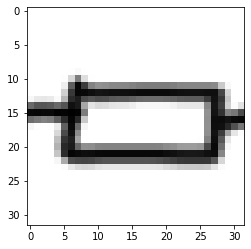

In [9]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
#new_model.summary()

img = convertImg(utils.loadImage(path='./', name='test.png', resize=(32,32)))

img = test_images[2]
#img = train_images[3]


predictions_single = model.predict(img.reshape(-1,32,32,1))[0]
print(class_names)
print(predictions_single)
print(class_names[np.where(predictions_single[:-4] == np.amax(predictions_single[:-4]))[0][0]])
print(class_names[np.where(predictions_single[-4:] == np.amax(predictions_single[-4:]))[0][0] + len(class_names) - 4])

plt.imshow(img, cmap='gray')

1/1 [==============================] - 0s 19ms/step - loss: 0.3631 - binary_accuracy: 0.8095
[[0 1 0 1 0 0 0]
 [1 0 0 0 0 1 1]
 [0 0 1 0 0 1 1]]
0.8095238208770752
0.36314383149147034


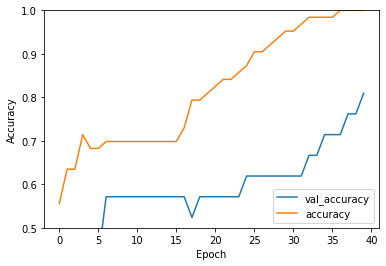

In [10]:
plt.plot(history.history['val_binary_accuracy'], label='val_accuracy')
plt.plot(history.history['binary_accuracy'], label = 'accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
#test_loss, test_acc = model.evaluate(train_images,  train_labels, verbose=1)
print(test_labels)
print(test_acc)
print(test_loss)